In [58]:
from pulp import *
from ALB_instance_tools import *
from MDP_functions import *
import numpy as np
import pandas as pd

# MDP model
taken from Markov decision process for multi-manned mixed-model assembly lines with walking workers Hasemi-Petroodi et. al. 2022

In [59]:
# instance_names = [
#     "SALBP_benchmark/small data set_n=20/instance_n=20_1.alb",
#     "SALBP_benchmark/small data set_n=20/instance_n=20_2.alb",
# ]
instance_names = ['SALBP_benchmark/debugging_ds/instance_n=3_1.alb','SALBP_benchmark/debugging_ds/instance_n=3_2.alb' ]
test_instances = create_instance_pairs(instance_names)
# Parameters
WORKER_COST = 500
NO_EQUIPMENT = 4
NO_S = 2
NO_MODELS = 2
TAKT_TIME = 150  # cadence to respect
MAX_L = 4  # maximum number of workers at a station
# STATION_MODEL_PICTURES  = {}

S_E = [(s, e) for s in range(NO_S) for e in range(NO_EQUIPMENT)]
S_L = [(s, l) for s in range(NO_S) for l in range(1, MAX_L)]

NO_CONFIG = NO_MODELS**NO_S  # Number of possible line pictures

#test_instances[0] = eliminate_tasks(test_instances[0], (.6,0.8))
test_instances[0] = eliminate_tasks(test_instances[0], (0,0))
for i in range(NO_MODELS):
    test_instances[0][i]["cycle_time"] = TAKT_TIME
    test_instances[0][i]["c_em"] = WORKER_COST
    test_instances[0][i]["max_workers"] = MAX_L

all_tasks = list_all_tasks(test_instances[0])
seed = np.random.randint(0, 1000)
c_se, r_oe = generate_equipment(NO_EQUIPMENT, NO_S, all_tasks, seed = 550)
stations = list(range(NO_S))
models = list(range(NO_MODELS))
model_pairs = list(itertools.combinations(models, 2))
omega = []
enumerate_universe("", omega, NO_MODELS, NO_S)
actions = list(range(len(all_tasks) ** NO_S))
# equipment = list(range(NO_EQUIPMENT))
# workers = list(range(1, MAX_L+1))

/var/folders/6v/7nrd1rj91hx3tb4q5npbdf0w0000gn/T/ipykernel_11293/1277260971.py:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


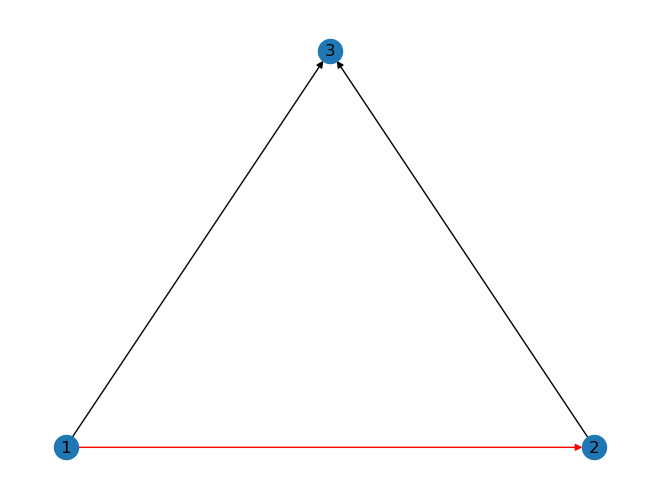

In [60]:
p_graph = nx.DiGraph()
p_graph.add_edges_from(test_instances[0][0]["precedence_relations"], color="r")
p_graph.add_edges_from(test_instances[0][1]["precedence_relations"], color="k")
colors = [p_graph[u][v]["color"] for u, v in p_graph.edges]
nx.draw_planar(p_graph, edge_color=colors, with_labels=True)
plt.tight_layout()
# plt.savefig("precedence_graph.png", format="PNG" )

In [61]:
test_instances[0]

[{'num_tasks': 3,
  'cycle_time': 150,
  'order_strength': 0.268,
  'task_times': {'1': 399, '2': 34, '3': 140},
  'precedence_relations': [('1', '2'), ('1', '3')],
  'model_no': 0,
  'c_em': 500,
  'max_workers': 4},
 {'num_tasks': 3,
  'cycle_time': 150,
  'order_strength': 0.3,
  'task_times': {'1': 300, '2': 224, '3': 180},
  'precedence_relations': [('1', '3'), ('2', '3')],
  'model_no': 1,
  'c_em': 500,
  'max_workers': 4}]

## MDP State
### State variables

In the paper we have:
F_isd -- Equal to 1 when model i is located at station s in state d, 0 otherwise

P_osd -- equal to 1 if model 1 if task o has been already executed for the the model in station s when the sytem passed to state d, 0 otherwise


R_osa -- equal to 1 if action a performs task o on the model in station s

However in the implementation we use the dictionaries D to contain the information in F_isd, P_osd, and A to contain the information in F_isd, P_osd, R_osa

### Transistion variables
Tr_a_d_dprime -- probability to transistion from state d to state d' with action a

Here we created a function that given a action, state, and next state will tell you the probability of the current state reaching the next state. (Way more space efficient than a matrix)

### Other parameters
q_as -- number of workers required in station s for action a
(This is also included in the dictionary A)

## MDP MILP
whew, finally

### Decision Variables

W_se -- 1 if equipment e is chosen for station s, 0 otherwise

X_ad -- probability of taking action a in state d

### Other variables
y_asoi -- 1 if task o is at station s for model i during action a (This is covered by the Action dictionary)


In [62]:
def make_dynamic_MILP():

    # Markov Decision Process state/action information
    no_line_pictures = len(omega)
    feasible_partitions = get_feasible_partitions(
    models, NO_S, all_tasks, test_instances[0]
        )
    model_histories = create_model_histories(feasible_partitions, models, NO_S)
    D = create_D(omega, model_histories, NO_S)
    
    A = create_A(D, model_histories, test_instances[0], all_tasks, TAKT_TIME, MAX_L, NO_S)
    #print("model histories", model_histories)
    # for d in D:
    #     print(d)
    for a in A:
        print(a)
    print(
        "length of D: ", 
        len(D),
        "length of A: ",
        len(A),
        ", length of omega:",
        len(omega),
    )

        # Decision Variables
    X_ad = LpVariable.dicts(
        "X_ad",
        (action["action_index"] for action in A),
        lowBound=0,
        upBound=1,
        cat=LpContinuous,
    )
    W_se = LpVariable.dicts("W_se", (S_E), lowBound=0, upBound=1, cat=LpBinary)
    
    prob = LpProblem("MDP", LpMinimize)
    prob += (
        lpSum(
            [
                X_ad[action["action_index"]] * WORKER_COST * action["total_workers"]
                for action in A
            ]
            + [W_se[s, e] * c_se[s, e] for s, e in S_E]
        ),
        "Total Cost",
    )


    for ind, d_prime in enumerate(D):
        d_prime_indices = [
            action["action_index"]
            for action in A
            if action["state_index"] == d_prime["index"]
        ]
        # constraint 3
        prob += (
            lpSum(
                [
                    X_ad[action["action_index"]]
                    * state_transistion_probability(
                        action, D[int(action["state_index"])], d_prime, NO_S
                    )
                    for action in A
                ]
            )
            == lpSum([X_ad[action] for action in d_prime_indices]),
            f"State_{d_prime['index']}_probability",
        )
    # constraint 4
    prob += (
        lpSum([X_ad[action["action_index"]] for action in A]) == 1,
        "Sum of probabilities",
    )
    for station in range(NO_S):
                    for a in A:
                        for task in a[f'action_at_{station}']:
                            # constraint 5
                            prob += (
                                X_ad[a["action_index"]]
                                <= lpSum(
                                    [
                                        r_oe[all_tasks.index(task)][equipment] * W_se[station, equipment]
                                        for equipment in range(NO_EQUIPMENT)
                                    ]
                                ),
                                f"equipment_for_o_{task}_s_{station}_a_{a['action_index']}",
                            )
    print("number of constraints", len(prob.constraints))
    print("number of variables", len(prob.variables()))
    return prob

prob = make_dynamic_MILP()
prob.solve(solver=XPRESS_PY(export="model.lp"))

for v in prob.variables():
    if v.varValue > 0:
        print(v.name, v.varValue)

{'model_at_0': '0', 'history_at_0': [], 'action_at_0': ['3', '1', '2'], 'total_task_time_at_0': 573, 'reduced_time_at_0': 143.25, 'workers_at_0': 4, 'model_at_1': '0', 'history_at_1': ['1'], 'action_at_1': ['3', '2'], 'total_task_time_at_1': 174, 'reduced_time_at_1': 87.0, 'workers_at_1': 2, 'state_index': 0, 'action_index': '0_0', 'total_workers': 6}
{'model_at_0': '0', 'history_at_0': [], 'action_at_0': ['3', '1'], 'total_task_time_at_0': 539, 'reduced_time_at_0': 134.75, 'workers_at_0': 4, 'model_at_1': '0', 'history_at_1': ['1'], 'action_at_1': ['3', '2'], 'total_task_time_at_1': 174, 'reduced_time_at_1': 87.0, 'workers_at_1': 2, 'state_index': 0, 'action_index': '0_1', 'total_workers': 6}
{'model_at_0': '0', 'history_at_0': [], 'action_at_0': ['1', '2'], 'total_task_time_at_0': 433, 'reduced_time_at_0': 144.33333333333334, 'workers_at_0': 3, 'model_at_1': '0', 'history_at_1': ['1'], 'action_at_1': ['3', '2'], 'total_task_time_at_1': 174, 'reduced_time_at_1': 87.0, 'workers_at_1': 

# Fixed Task assignment MILP, Model Dependent Task Assignment MILP


Taken from Model-dependent task assignment in multi-manned mixed-model assembly lines with walking workers Hashemi-Petroodi 2022. He we modified the equipment cost constraints so instead of having to pay for a piece of equipment for each worker, we pay for a piece of equipment for the station.
## Decision Variables
NOTICE-- here I am using w as omega

Y -- # workers \
u_se -- # of pieces of equipment e at station s \
b_wsl --  1 if there are l workers in station s for picture w, 0 otherwise\
b_woisl -- 1 if there are l workers performing task o on model i at station s for picture w, 0 otherwise\
x_soi -- 1 if task o is performed on model i at station s, 0 otherwise

In [63]:
def fixed_assignment_problem(model_dependent = False):
    #variables
    workers = list(range(1, MAX_L+1))
    equipment = list(range(NO_EQUIPMENT))
    y = LpVariable("Y", lowBound=0, cat=LpInteger)
    u_se = LpVariable.dicts('u_se',(stations,equipment), lowBound=0, cat= LpBinary)
    b_wsl = LpVariable.dicts('b_wsl', (range(NO_CONFIG), stations, workers), lowBound=0, upBound=1, cat=LpBinary )
    b_woisl = LpVariable.dicts('b_woisl',(range(NO_CONFIG), all_tasks, models, stations, workers),lowBound=0, upBound=1, cat=LpBinary)
    x_soi = LpVariable.dicts('x_soi', (stations, all_tasks, models), lowBound=0, cat=LpBinary)
    if model_dependent:
        prob = pulp.LpProblem("MALBP-W-Model_Dependent", LpMinimize)
    else:
         prob = pulp.LpProblem("MALBP-W_fixed", LpMinimize)

    #Calculate the task times for each task with a certain number of workers
    for test_instance in test_instances:
        for model in test_instance:
            model[f'task_times_l'] = {}
            for i in workers:
                model[f'task_times_l'][i] = linear_reduction(model['task_times'], i)
    #Define the problem, add an objective function and the constraints
    prob += ( lpSum([WORKER_COST * y] + [c_se[s][e]* u_se[s][e] for (s,e) in S_E]), 'TOTAL_COST')
    prob = add_constraints_for_fixed_assignment(prob, b_wsl, b_woisl, x_soi, u_se, workers,equipment, y, model_dependent)
    return prob

def add_constraints_for_fixed_assignment(prob, b_wsl, b_woisl, x_soi, u_se, workers,equipment, y, model_dependent = False):
    for w_in, w in enumerate(omega):
        #Constraint 2 in MILP_fix
        prob += pulp.lpSum([l * b_wsl[w_in][s][l] for s in stations for l in workers])<= y, ("tot Workers Pic" + str(w) ) 
        for s_in, s in enumerate(stations):
            #Constraint 3 in MILP_fix
            prob += pulp.lpSum([b_wsl[w_in][s_in][l] for l in workers])==1, (f'workers_at_station_{s}_pic_{w}') 
            model_at_s = omega[w_in][s_in]
            tasks = test_instances[0][int(model_at_s)]['task_times_l']
            #constraint 9 
            prob += pulp.lpSum([tasks[l][task]*b_woisl[w_in][task][int(model_at_s)][s_in][l] for l in workers for task in tasks[l].keys() ]) <= TAKT_TIME, (f'C for picture {w}, station {s}')
    
            for l in workers:
                for i in models:
                    for o in test_instances[0][i]['task_times']:
                        #const. 10
                        prob +=  b_woisl[w_in][o][i][s][l] <= pulp.lpSum([r_oe[int(o)-1][e] * u_se[s_in][e] for e in equipment]), (f' e that can cover woisl {w} {o} {i} {s} {l} ')
        
    for i in models:
        for task in test_instances[0][i]['task_times']:
                 #constraint 4
                prob+= pulp.lpSum([x_soi[s][task][i] for s in stations]) == 1, (f'task_{task}_assignment_model_{i}')
        for (pred, suc) in test_instances[0][i]['precedence_relations']:
            #constraint 11
            prob += pulp.lpSum([ (s+1)  * x_soi[s][pred][i] for s in stations]) <=  pulp.lpSum([ (s+1)  * x_soi[s][suc][i] for s in stations]), (f'task{pred} before task{suc} for model{i}') 

    if not model_dependent:  
        for m1, m2 in model_pairs:
            shared_tasks = get_task_intersection(test_instances[0], m1, m2)
            for task in shared_tasks:
                for s in stations:
                    #constraint 5
                    prob += x_soi[s][task][m1] == x_soi[s][task][m2], (f'task {task} for models {m1, m2} at s {s}')
    
    for w_in, w in enumerate(omega):
        for l in workers:
            for i in models:
                for o in test_instances[0][i]['task_times']:
                    for s_in, station_picture in enumerate(w):
                        #if str(i) == station_picture:
                            print(w)
                            print('s_in', s_in, 'o', o, 'i', i, 'l', l, 'w_in', w_in)
                            #It  seems that for fixed model assignment we are forcing the same number of workers to be assigned to each station
                            prob += b_woisl[w_in][o][i][s_in][l] <= x_soi[s_in][o][i], (f'{l} workers task{o} s{s_in} pic {w_in} mod {i} x_soi on') #constraint 6
                            prob += b_woisl[w_in][o][i][s_in][l] <= b_wsl[w_in][s_in][l],(f'{l} workers task{o} s{s_in} pic {w_in} mod {i} b_wsl on') #constraint 7
                            prob += b_woisl[w_in][o][i][s_in][l] >= b_wsl[w_in][s_in][l] + x_soi[s_in][o][i] - 1, (f'{l} workers task {o} s{s_in} pic {w_in} mod {i} b_wsl x_soi coord') #constraint 8
    return prob

fix_prob = fixed_assignment_problem()
model_dependent_prob =fixed_assignment_problem(model_dependent=True)
fix_prob

['0', '0']
s_in 0 o 1 i 0 l 1 w_in 0
['0', '0']
s_in 1 o 1 i 0 l 1 w_in 0
['0', '0']
s_in 0 o 2 i 0 l 1 w_in 0
['0', '0']
s_in 1 o 2 i 0 l 1 w_in 0
['0', '0']
s_in 0 o 3 i 0 l 1 w_in 0
['0', '0']
s_in 1 o 3 i 0 l 1 w_in 0
['0', '0']
s_in 0 o 1 i 1 l 1 w_in 0
['0', '0']
s_in 1 o 1 i 1 l 1 w_in 0
['0', '0']
s_in 0 o 2 i 1 l 1 w_in 0
['0', '0']
s_in 1 o 2 i 1 l 1 w_in 0
['0', '0']
s_in 0 o 3 i 1 l 1 w_in 0
['0', '0']
s_in 1 o 3 i 1 l 1 w_in 0
['0', '0']
s_in 0 o 1 i 0 l 2 w_in 0
['0', '0']
s_in 1 o 1 i 0 l 2 w_in 0
['0', '0']
s_in 0 o 2 i 0 l 2 w_in 0
['0', '0']
s_in 1 o 2 i 0 l 2 w_in 0
['0', '0']
s_in 0 o 3 i 0 l 2 w_in 0
['0', '0']
s_in 1 o 3 i 0 l 2 w_in 0
['0', '0']
s_in 0 o 1 i 1 l 2 w_in 0
['0', '0']
s_in 1 o 1 i 1 l 2 w_in 0
['0', '0']
s_in 0 o 2 i 1 l 2 w_in 0
['0', '0']
s_in 1 o 2 i 1 l 2 w_in 0
['0', '0']
s_in 0 o 3 i 1 l 2 w_in 0
['0', '0']
s_in 1 o 3 i 1 l 2 w_in 0
['0', '0']
s_in 0 o 1 i 0 l 3 w_in 0
['0', '0']
s_in 1 o 1 i 0 l 3 w_in 0
['0', '0']
s_in 0 o 2 i 0 l 3 w_in 0
[

MALBP-W_fixed:
MINIMIZE
500*Y + 295*u_se_0_0 + 164*u_se_0_1 + 258*u_se_0_2 + 281*u_se_0_3 + 194*u_se_1_0 + 295*u_se_1_1 + 265*u_se_1_2 + 238*u_se_1_3 + 0
SUBJECT TO
tot_Workers_Pic_'0',_'0'_: - Y + b_wsl_0_0_1 + 2 b_wsl_0_0_2 + 3 b_wsl_0_0_3
 + 4 b_wsl_0_0_4 + b_wsl_0_1_1 + 2 b_wsl_0_1_2 + 3 b_wsl_0_1_3 + 4 b_wsl_0_1_4
 <= 0

workers_at_station_0_pic__'0',_'0'_: b_wsl_0_0_1 + b_wsl_0_0_2 + b_wsl_0_0_3
 + b_wsl_0_0_4 = 1

C_for_picture__'0',_'0'_,_station_0: 399 b_woisl_0_1_0_0_1
 + 199.5 b_woisl_0_1_0_0_2 + 133 b_woisl_0_1_0_0_3 + 99.75 b_woisl_0_1_0_0_4
 + 34 b_woisl_0_2_0_0_1 + 17 b_woisl_0_2_0_0_2
 + 11.3333333333 b_woisl_0_2_0_0_3 + 8.5 b_woisl_0_2_0_0_4
 + 140 b_woisl_0_3_0_0_1 + 70 b_woisl_0_3_0_0_2
 + 46.6666666667 b_woisl_0_3_0_0_3 + 35 b_woisl_0_3_0_0_4 <= 150

_e_that_can_cover_woisl__'0',_'0'__1_0_0_1_: b_woisl_0_1_0_0_1 - u_se_0_0
 - u_se_0_2 - u_se_0_3 <= 0

_e_that_can_cover_woisl__'0',_'0'__2_0_0_1_: b_woisl_0_2_0_0_1 - u_se_0_0
 - u_se_0_1 - u_se_0_2 - u_se_0_3 <= 0

_e

In [64]:
fix_prob

MALBP-W_fixed:
MINIMIZE
500*Y + 295*u_se_0_0 + 164*u_se_0_1 + 258*u_se_0_2 + 281*u_se_0_3 + 194*u_se_1_0 + 295*u_se_1_1 + 265*u_se_1_2 + 238*u_se_1_3 + 0
SUBJECT TO
tot_Workers_Pic_'0',_'0'_: - Y + b_wsl_0_0_1 + 2 b_wsl_0_0_2 + 3 b_wsl_0_0_3
 + 4 b_wsl_0_0_4 + b_wsl_0_1_1 + 2 b_wsl_0_1_2 + 3 b_wsl_0_1_3 + 4 b_wsl_0_1_4
 <= 0

workers_at_station_0_pic__'0',_'0'_: b_wsl_0_0_1 + b_wsl_0_0_2 + b_wsl_0_0_3
 + b_wsl_0_0_4 = 1

C_for_picture__'0',_'0'_,_station_0: 399 b_woisl_0_1_0_0_1
 + 199.5 b_woisl_0_1_0_0_2 + 133 b_woisl_0_1_0_0_3 + 99.75 b_woisl_0_1_0_0_4
 + 34 b_woisl_0_2_0_0_1 + 17 b_woisl_0_2_0_0_2
 + 11.3333333333 b_woisl_0_2_0_0_3 + 8.5 b_woisl_0_2_0_0_4
 + 140 b_woisl_0_3_0_0_1 + 70 b_woisl_0_3_0_0_2
 + 46.6666666667 b_woisl_0_3_0_0_3 + 35 b_woisl_0_3_0_0_4 <= 150

_e_that_can_cover_woisl__'0',_'0'__1_0_0_1_: b_woisl_0_1_0_0_1 - u_se_0_0
 - u_se_0_2 - u_se_0_3 <= 0

_e_that_can_cover_woisl__'0',_'0'__2_0_0_1_: b_woisl_0_2_0_0_1 - u_se_0_0
 - u_se_0_1 - u_se_0_2 - u_se_0_3 <= 0

_e

In [65]:
#path_to_cplex = '/Applications/CPLEX_Studio_Community2211/cplex/bin/x86-64_osx/cplex'
# solver = CPLEX_CMD(path=path_to_cplex, msg=True)
#solver = getSolver('CPLEX_PY')
#prob.numVariables()
fix_prob.solve(solver=XPRESS_PY())

FICO Xpress v9.0.3, Community, solve started 17:48:55, Jun 14, 2023
Heap usage: 621KB (peak 621KB, 1233KB system)
Minimizing MILP noname using up to 8 threads and up to 8192MB memory, with these control settings:
OUTPUTLOG = 1
Original problem has:
       804 rows          245 cols         2444 elements       245 entities
Presolved problem has:
        90 rows           44 cols          256 elements        44 entities
LP relaxation tightened
Presolve finished in 0 seconds
Heap usage: 669KB (peak 1086KB, 1233KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e+00,  3.99e+02] / [ 8.85e-02,  1.80e+00]
  RHS and bounds [min,max] : [ 1.00e+00,  1.50e+02] / [ 2.66e-01,  9.00e+00]
  Objective      [min,max] : [ 1.64e+02,  5.00e+02] / [ 5.00e+02,  5.00e+02]
Autoscaling applied standard scaling

Will try to keep branch and bound tree memory usage below 7.5GB
 *** Solution found:  3952.000000   Time:   0.01    Heuristic: e 

1

In [66]:
def generate_task_assignments_df(pulp_prob):
    '''Shows task assignments for fixed and model dependent task assignment'''
    task_assignments = []
    labor_assignments = []
    for v in pulp_prob.variables():
        if v.varValue > 0:
            print(v.name, v.varValue)
            if 'x_soi' in v.name:
                assignment = {'station': v.name.split('_')[2], 'task': v.name.split('_')[3], 'model': v.name.split('_')[4], 'task_times': int(test_instances[0][int(v.name.split('_')[4])]['task_times'][v.name.split('_')[3]])}
                task_assignments.append(assignment)
            elif 'b_wsl' in v.name:
                labor = {'model':omega[int(v.name.split('_')[2])][int(v.name.split('_')[3])], 'station': v.name.split('_')[3],  'workers': int(v.name.split('_')[4]) }
                labor_assignments.append(labor)

    #turns task_assignments into a dataframe
    task_assignments_df = pd.DataFrame(task_assignments)
    labor_assignments_df = pd.DataFrame(labor_assignments)
    #concatenates the 'task' column in task_assignments_df if the 'station' and 'model' columns are the same
    task_assignments_df = task_assignments_df.groupby(['station', 'model'])['task', 'task_times'].agg({'task':lambda x: ','.join(x.astype(str)), 'task_times': sum }).reset_index()
    #concatenates the 'task' column in labor_assignments_df if the 'station' and 'model' columns are the same
    labor_assignments_df = labor_assignments_df.groupby(['model','station'])[ 'workers'].apply( max).reset_index()
    #print(labor_assignments_df)
    #concatenates the 'workers' column in labor_assignments_df  to the task_assignments_df if the 'station' and 'model' columns are the same
    task_assignments_df = pd.merge(task_assignments_df, labor_assignments_df, on=['station', 'model'])
    return task_assignments_df
fixed_task_assignments_df = generate_task_assignments_df(fix_prob)
fixed_task_assignments_df

Y 6.0
b_woisl_0_1_0_0_4 1.0
b_woisl_0_1_1_0_4 1.0
b_woisl_0_2_0_0_4 1.0
b_woisl_0_2_1_0_4 1.0
b_woisl_0_3_0_1_2 1.0
b_woisl_0_3_1_1_2 1.0
b_woisl_1_1_0_0_4 1.0
b_woisl_1_1_1_0_4 1.0
b_woisl_1_2_0_0_4 1.0
b_woisl_1_2_1_0_4 1.0
b_woisl_1_3_0_1_2 1.0
b_woisl_1_3_1_1_2 1.0
b_woisl_2_1_0_0_4 1.0
b_woisl_2_1_1_0_4 1.0
b_woisl_2_2_0_0_4 1.0
b_woisl_2_2_1_0_4 1.0
b_woisl_2_3_0_1_2 1.0
b_woisl_2_3_1_1_2 1.0
b_woisl_3_1_0_0_4 1.0
b_woisl_3_1_1_0_4 1.0
b_woisl_3_2_0_0_4 1.0
b_woisl_3_2_1_0_4 1.0
b_woisl_3_3_0_1_2 1.0
b_woisl_3_3_1_1_2 1.0
b_wsl_0_0_4 1.0
b_wsl_0_1_2 1.0
b_wsl_1_0_4 1.0
b_wsl_1_1_2 1.0
b_wsl_2_0_4 1.0
b_wsl_2_1_2 1.0
b_wsl_3_0_4 1.0
b_wsl_3_1_2 1.0
u_se_0_2 1.0
u_se_1_0 1.0
x_soi_0_1_0 1.0
x_soi_0_1_1 1.0
x_soi_0_2_0 1.0
x_soi_0_2_1 1.0
x_soi_1_3_0 1.0
x_soi_1_3_1 1.0


/var/folders/6v/7nrd1rj91hx3tb4q5npbdf0w0000gn/T/ipykernel_11293/2890756343.py:19: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  task_assignments_df = task_assignments_df.groupby(['station', 'model'])['task', 'task_times'].agg({'task':lambda x: ','.join(x.astype(str)), 'task_times': sum }).reset_index()


,station,model,task,task_times,workers
0,0,0,"1,2",433,4
1,0,1,"1,2",524,4
2,1,0,3,140,2
3,1,1,3,180,2


In [67]:
omega[1]

['0', '1']

In [68]:
varsdict = {}
for v in fix_prob.variables():
    if v.varValue > 0:
        print(v.name, v.varValue)

Y 6.0
b_woisl_0_1_0_0_4 1.0
b_woisl_0_1_1_0_4 1.0
b_woisl_0_2_0_0_4 1.0
b_woisl_0_2_1_0_4 1.0
b_woisl_0_3_0_1_2 1.0
b_woisl_0_3_1_1_2 1.0
b_woisl_1_1_0_0_4 1.0
b_woisl_1_1_1_0_4 1.0
b_woisl_1_2_0_0_4 1.0
b_woisl_1_2_1_0_4 1.0
b_woisl_1_3_0_1_2 1.0
b_woisl_1_3_1_1_2 1.0
b_woisl_2_1_0_0_4 1.0
b_woisl_2_1_1_0_4 1.0
b_woisl_2_2_0_0_4 1.0
b_woisl_2_2_1_0_4 1.0
b_woisl_2_3_0_1_2 1.0
b_woisl_2_3_1_1_2 1.0
b_woisl_3_1_0_0_4 1.0
b_woisl_3_1_1_0_4 1.0
b_woisl_3_2_0_0_4 1.0
b_woisl_3_2_1_0_4 1.0
b_woisl_3_3_0_1_2 1.0
b_woisl_3_3_1_1_2 1.0
b_wsl_0_0_4 1.0
b_wsl_0_1_2 1.0
b_wsl_1_0_4 1.0
b_wsl_1_1_2 1.0
b_wsl_2_0_4 1.0
b_wsl_2_1_2 1.0
b_wsl_3_0_4 1.0
b_wsl_3_1_2 1.0
u_se_0_2 1.0
u_se_1_0 1.0
x_soi_0_1_0 1.0
x_soi_0_1_1 1.0
x_soi_0_2_0 1.0
x_soi_0_2_1 1.0
x_soi_1_3_0 1.0
x_soi_1_3_1 1.0


In [69]:
omega

[['0', '0'], ['0', '1'], ['1', '0'], ['1', '1']]

In [70]:
model_dependent_prob.solve(solver=XPRESS_PY())

FICO Xpress v9.0.3, Community, solve started 17:48:55, Jun 14, 2023
Heap usage: 621KB (peak 621KB, 1600KB system)
Minimizing MILP noname using up to 8 threads and up to 8192MB memory, with these control settings:
OUTPUTLOG = 1
Original problem has:
       798 rows          245 cols         2432 elements       245 entities
Presolved problem has:
       404 rows          140 cols         1081 elements       140 entities
LP relaxation tightened
Presolve finished in 0 seconds
Heap usage: 738KB (peak 1101KB, 1600KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e+00,  3.99e+02] / [ 6.64e-02,  1.75e+00]
  RHS and bounds [min,max] : [ 1.00e+00,  1.50e+02] / [ 8.98e-01,  1.40e+01]
  Objective      [min,max] : [ 1.64e+02,  5.00e+02] / [ 1.64e+02,  5.00e+02]
Autoscaling applied standard scaling

Will try to keep branch and bound tree memory usage below 7.5GB
 *** Solution found:  3452.000000   Time:   0.01    Heuristic: e 

1

In [71]:
fixed = generate_task_assignments_df(fix_prob)
fixed

Y 6.0
b_woisl_0_1_0_0_4 1.0
b_woisl_0_1_1_0_4 1.0
b_woisl_0_2_0_0_4 1.0
b_woisl_0_2_1_0_4 1.0
b_woisl_0_3_0_1_2 1.0
b_woisl_0_3_1_1_2 1.0
b_woisl_1_1_0_0_4 1.0
b_woisl_1_1_1_0_4 1.0
b_woisl_1_2_0_0_4 1.0
b_woisl_1_2_1_0_4 1.0
b_woisl_1_3_0_1_2 1.0
b_woisl_1_3_1_1_2 1.0
b_woisl_2_1_0_0_4 1.0
b_woisl_2_1_1_0_4 1.0
b_woisl_2_2_0_0_4 1.0
b_woisl_2_2_1_0_4 1.0
b_woisl_2_3_0_1_2 1.0
b_woisl_2_3_1_1_2 1.0
b_woisl_3_1_0_0_4 1.0
b_woisl_3_1_1_0_4 1.0
b_woisl_3_2_0_0_4 1.0
b_woisl_3_2_1_0_4 1.0
b_woisl_3_3_0_1_2 1.0
b_woisl_3_3_1_1_2 1.0
b_wsl_0_0_4 1.0
b_wsl_0_1_2 1.0
b_wsl_1_0_4 1.0
b_wsl_1_1_2 1.0
b_wsl_2_0_4 1.0
b_wsl_2_1_2 1.0
b_wsl_3_0_4 1.0
b_wsl_3_1_2 1.0
u_se_0_2 1.0
u_se_1_0 1.0
x_soi_0_1_0 1.0
x_soi_0_1_1 1.0
x_soi_0_2_0 1.0
x_soi_0_2_1 1.0
x_soi_1_3_0 1.0
x_soi_1_3_1 1.0


/var/folders/6v/7nrd1rj91hx3tb4q5npbdf0w0000gn/T/ipykernel_11293/2890756343.py:19: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  task_assignments_df = task_assignments_df.groupby(['station', 'model'])['task', 'task_times'].agg({'task':lambda x: ','.join(x.astype(str)), 'task_times': sum }).reset_index()


,station,model,task,task_times,workers
0,0,0,"1,2",433,4
1,0,1,"1,2",524,4
2,1,0,3,140,2
3,1,1,3,180,2


In [72]:
task_assignments_df = generate_task_assignments_df(model_dependent_prob)
task_assignments_df

Y 6.0
b_woisl_0_1_0_1_4 1.0
b_woisl_0_1_1_1_4 1.0
b_woisl_0_2_0_1_4 1.0
b_woisl_0_2_1_0_2 1.0
b_woisl_0_3_0_1_4 1.0
b_woisl_0_3_1_1_4 1.0
b_woisl_1_1_0_1_4 1.0
b_woisl_1_1_1_1_4 1.0
b_woisl_1_2_0_1_4 1.0
b_woisl_1_2_1_0_2 1.0
b_woisl_1_3_0_1_4 1.0
b_woisl_1_3_1_1_4 1.0
b_woisl_2_1_0_1_4 1.0
b_woisl_2_1_1_1_4 1.0
b_woisl_2_2_0_1_4 1.0
b_woisl_2_2_1_0_2 1.0
b_woisl_2_3_0_1_4 1.0
b_woisl_2_3_1_1_4 1.0
b_woisl_3_1_0_1_4 1.0
b_woisl_3_1_1_1_4 1.0
b_woisl_3_2_0_1_4 1.0
b_woisl_3_2_1_0_2 1.0
b_woisl_3_3_0_1_4 1.0
b_woisl_3_3_1_1_4 1.0
b_wsl_0_0_2 1.0
b_wsl_0_1_4 1.0
b_wsl_1_0_2 1.0
b_wsl_1_1_4 1.0
b_wsl_2_0_2 1.0
b_wsl_2_1_4 1.0
b_wsl_3_0_2 1.0
b_wsl_3_1_4 1.0
u_se_0_1 1.0
u_se_1_0 1.0
x_soi_0_2_1 1.0
x_soi_1_1_0 1.0
x_soi_1_1_1 1.0
x_soi_1_2_0 1.0
x_soi_1_3_0 1.0
x_soi_1_3_1 1.0


/var/folders/6v/7nrd1rj91hx3tb4q5npbdf0w0000gn/T/ipykernel_11293/2890756343.py:19: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  task_assignments_df = task_assignments_df.groupby(['station', 'model'])['task', 'task_times'].agg({'task':lambda x: ','.join(x.astype(str)), 'task_times': sum }).reset_index()


,station,model,task,task_times,workers
0,0,1,2,224,2
1,1,0,"1,2,3",573,4
2,1,1,"1,3",480,4


In [73]:
print("Dynamic obj value", value(prob.objective), "fixed obj value", value(fix_prob.objective), "model dependent obj value", value(model_dependent_prob.objective))
#print('random seed', seed)

Dynamic obj value 2657.9999999999995 fixed obj value 3452.0 model dependent obj value 3358.0


#TODO Try to force fixed solution in dynamic and see the resulting cost


In [74]:
print('r_oe',r_oe, '\n c_se', c_se)

r_oe [[ True False  True  True]
 [ True  True  True  True]
 [ True  True  True  True]] 
 c_se [[295 164 258 281]
 [194 295 265 238]]


In [75]:
print('0,1', c_se[0,1], '0,2', c_se[0,2], '1,0', c_se[1,0])

0,1 164 0,2 258 1,0 194


In [76]:
r_oe[0,1]

False